In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os

In [2]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])

In [3]:
def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

Looking for 0.jpg...
Enough matches are found - 209/100
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter vot

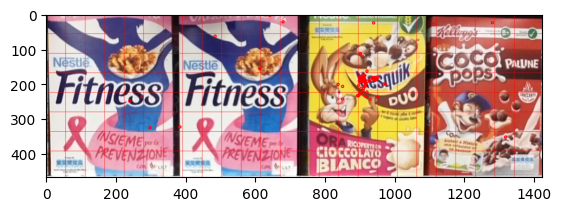

Looking for 1.jpg...
Not enough matches are found - 78/100
Looking for 25.jpg...
Enough matches are found - 258/100
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range


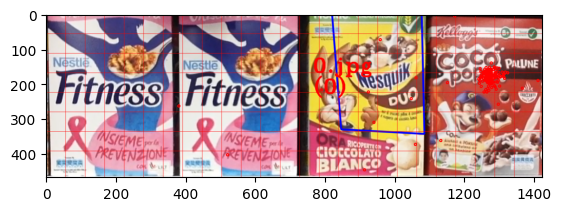

Looking for 26.jpg...
Enough matches are found - 262/100
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range
barycenter votes out of range


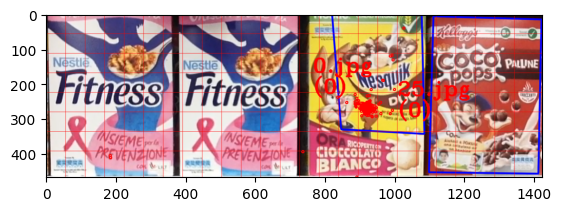

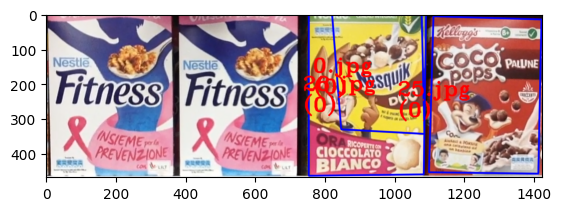

In [23]:
def find_image(scene_path, model_paths, draw_on_color=True):
    target_resolution = (150, 210)
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print(f"Looking for {model["name"]}...")

        model_gray = model["img"]
        #_model_gray = model["img"]
        #model_gray = cv.resize(_model_gray, target_resolution, interpolation=cv.INTER_AREA)
        MIN_MATCH_COUNT = 100

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on

        if len(good)>MIN_MATCH_COUNT:
            print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            
            src_kp = [kp_model[m.queryIdx] for m in good]
            dst_kp = [kp_scene[m.trainIdx] for m in good]


            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            #draw barycenter
            tmp = model_gray.copy()
            #cv.circle(tmp, barycenter, 3, (0,0,255), 2)
            #plt.imshow(tmp)
            #plt.show()

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            tmp = scene_to_draw_on.copy()

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                #delta_phi = d.angle/s.angle
                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)

                #cv.line(tmp, bary_predict, [int(pt_x), int(pt_y)], (0,0,255), 1)

            #plt.imshow(tmp)
            #plt.show()


            GRID_RESOLUTION = 25
            MIN_VOTES = 25
            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)
            #grid = np.zeros((GRID_RESOLUTION, GRID_RESOLUTION))

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            #print("Scene:", scene_gray.shape)
            #print("Grid:", grid)

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    #print((x_idx, y_idx))
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)
                else:
                    print("barycenter votes out of range")

            barygrid_means = []
            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        #print(f"({i},{j}):{len(grid[i][j])}")
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))

            
            #draw grid
            image = scene_to_draw_on.copy()
            height, width, _ = image.shape

            num_vertical_lines = width // x_cell
            num_horizontal_lines = height // y_cell

            for i in range(1, num_vertical_lines):
                x = i * x_cell
                cv.line(image, (x, 0), (x, height), color=(0, 0, 255), thickness=1)

            for i in range(1, num_horizontal_lines):
                y = i * y_cell
                cv.line(image, (0, y), (width, y), color=(0, 0, 255), thickness=1)
            
            for o in barycenter_votes:
                cv.circle(image, o, 3, (0,0,255), 2)
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.show()
            ############

            

            i = 0

            ignored_area = []

            for winner, barygrid_mean in zip(winners, barygrid_means):

                foo = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        foo = True
                        break
                if foo:
                    continue


                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                matchesMask = mask.ravel().tolist()
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,
                                                h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                #add square and add text
                means = np.mean(dst, axis=0)
                x, y = [a for a in means[0]]
                x = x * 0.8 #adjust for text

                result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

                boldness = 3
                size = 3
                cv.putText(scene_to_draw_on, f"{model["name"]}", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                cv.putText(scene_to_draw_on, f"({i})", (int(x),int(y)+60), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                i = i + 1

                ignored_area.append([o[0] for o in np.int32(dst)])

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    #print("------------------------------------------")
    #print("Results:")
    return result


#define models to be searched in image
models = [get_path_model(a) for a in [0,1, 25,26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m1.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()